In [1]:
#libraries
import numpy as np 
from numba import jit
import pandas as pd 
from datetime import datetime as dt
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
import gc
from catboost import CatBoostClassifier
from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)
import os
print(os.listdir("../input"))


['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

In [3]:
#https://www.kaggle.com/theoviel/load-the-totality-of-the-data
dtypes = {
    'MachineIdentifier':                                    'object',
    'ProductName':                                          'object',
    'EngineVersion':                                        'object',
    'AppVersion':                                           'object',
    'AvSigVersion':                                         'object',
    'IsBeta':                                               'int8',
    'RtpStateBitfield':                                     'float16',
    'IsSxsPassiveMode':                                     'int8',
    'DefaultBrowsersIdentifier':                            'float32',  # was 'float16'
    'AVProductStatesIdentifier':                            'float32',
    'AVProductsInstalled':                                  'float16',
    'AVProductsEnabled':                                    'float16',
    'HasTpm':                                               'int8',
    'CountryIdentifier':                                    'int16',
    'CityIdentifier':                                       'float32',
    'OrganizationIdentifier':                               'float16',
    'GeoNameIdentifier':                                    'float16',
    'LocaleEnglishNameIdentifier':                          'int16',  # was 'int8'
    'Platform':                                             'object',
    'Processor':                                            'object',
    'OsVer':                                                'object',
    'OsBuild':                                              'int16',
    'OsSuite':                                              'int16',
    'OsPlatformSubRelease':                                 'object',
    'OsBuildLab':                                           'object',
    'SkuEdition':                                           'object',
    'IsProtected':                                          'float16',
    'AutoSampleOptIn':                                      'int8',
    'PuaMode':                                              'object',
    'SMode':                                                'float16',
    'IeVerIdentifier':                                      'float16',
    'SmartScreen':                                          'object',
    'Firewall':                                             'float16',
    'UacLuaenable':                                         'float64', # was 'float32'
    'Census_MDC2FormFactor':                                'object',
    'Census_DeviceFamily':                                  'object',
    'Census_OEMNameIdentifier':                             'float32', # was 'float16'
    'Census_OEMModelIdentifier':                            'float32',
    'Census_ProcessorCoreCount':                            'float16',
    'Census_ProcessorManufacturerIdentifier':               'float16',
    'Census_ProcessorModelIdentifier':                      'float32', # was 'float16'
    'Census_ProcessorClass':                                'object',
    'Census_PrimaryDiskTotalCapacity':                      'float64', # was 'float32'
    'Census_PrimaryDiskTypeName':                           'object',
    'Census_SystemVolumeTotalCapacity':                     'float64', # was 'float32'
    'Census_HasOpticalDiskDrive':                           'int8',
    'Census_TotalPhysicalRAM':                              'float32',
    'Census_ChassisTypeName':                               'object',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', # was 'float16'
    'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', # was 'float16'
    'Census_InternalPrimaryDisplayResolutionVertical':      'float32', # was 'float16'
    'Census_PowerPlatformRoleName':                         'object',
    'Census_InternalBatteryType':                           'object',
    'Census_InternalBatteryNumberOfCharges':                'float64', # was 'float32'
    'Census_OSVersion':                                     'object',
    'Census_OSArchitecture':                                'object',
    'Census_OSBranch':                                      'object',
    'Census_OSBuildNumber':                                 'int16',
    'Census_OSBuildRevision':                               'int32',
    'Census_OSEdition':                                     'object',
    'Census_OSSkuName':                                     'object',
    'Census_OSInstallTypeName':                             'object',
    'Census_OSInstallLanguageIdentifier':                   'float16',
    'Census_OSUILocaleIdentifier':                          'int16',
    'Census_OSWUAutoUpdateOptionsName':                     'object',
    'Census_IsPortableOperatingSystem':                     'int8',
    'Census_GenuineStateName':                              'object',
    'Census_ActivationChannel':                             'object',
    'Census_IsFlightingInternal':                           'float16',
    'Census_IsFlightsDisabled':                             'float16',
    'Census_FlightRing':                                    'object',
    'Census_ThresholdOptIn':                                'float16',
    'Census_FirmwareManufacturerIdentifier':                'float16',
    'Census_FirmwareVersionIdentifier':                     'float32',
    'Census_IsSecureBootEnabled':                           'int8',
    'Census_IsWIMBootEnabled':                              'float16',
    'Census_IsVirtualDevice':                               'float16',
    'Census_IsTouchEnabled':                                'int8',
    'Census_IsPenCapable':                                  'int8',
    'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
    'Wdft_IsGamer':                                         'float16',
    'Wdft_RegionIdentifier':                                'float16',
    'HasDetections':                                        'float32',
}

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

In [5]:
%%time
train = pd.read_csv('../input/train.csv', dtype=dtypes)

CPU times: user 1min 44s, sys: 16 s, total: 2min
Wall time: 2min


In [6]:
random_sample_percent = 5/8
random_state = 15
number_of_folds = 5
stop_after_fold_number = 1
shuffle = True

In [7]:
# To match the R kernel - https://www.kaggle.com/hung96ad/lightgbm
if random_sample_percent is not None:
    train = train.sample(frac=random_sample_percent, random_state=random_state)

In [8]:
train_y = train['HasDetections']

In [9]:
train = reduce_mem_usage(train)

Mem. usage decreased to 10894.33 Mb (1.4% reduction)


In [10]:
test = pd.read_csv('../input/test.csv', dtype=dtypes)
# test.loc[6529507, 'OsBuildLab'] = '17134.1.amd64fre.rs4_release.180410-1804'
test = reduce_mem_usage(test)

Mem. usage decreased to 15201.62 Mb (1.4% reduction)


In [11]:
# train.drop('AvSigVersion', inplace=True, axis=1)
# test.drop('AvSigVersion', inplace=True, axis=1)
# categorical_columns.remove('AvSigVersion')
# train.drop('Census_OSVersion', inplace=True, axis=1)
# test.drop('Census_OSVersion', inplace=True, axis=1)
# categorical_columns.remove('Census_OSVersion')

In [12]:
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
4027792,7392774d0e836406e9dd1349b306d0f5,win8defender,1.1.15200.1,4.18.1807.18075,1.273.1723.0,0,7.0,0,NaN,7945.0,2.0,1.0,1,44,164956.0,27.0,57.0,218,windows10,x64,10.0.0.0,16299,768,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,1.0,0,NaN,0.0,111.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,171319.0,2.0,5.0,1998.0,NaN,476940.0,HDD,432379.0,0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,0.0,10.0.16299.192,amd64,rs3_release,16299,192,CoreSingleLanguage,CORE_SINGLELANGUAGE,Upgrade,9.0,34,Notify,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,628.0,8789.0,1,NaN,0.0,0,0,0.0,1.0,10.0,0.0
751446,159668c400fc3734ba9eb8efeed85ab7,win8defender,1.1.15100.1,4.18.1807.18075,1.273.810.0,0,7.0,0,NaN,62773.0,1.0,1.0,1,142,74924.0,27.0,157.0,68,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,0.0,0,NaN,0.0,108.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2668.0,171152.0,2.0,5.0,1985.0,NaN,476940.0,HDD,217671.0,0,2048.0,Notebook,15.500000,1366.0,768.0,Mobile,li-i,0.0,10.0.15063.1155,amd64,rs2_release,15063,1155,CoreSingleLanguage,CORE_SINGLELANGUAGE,Update,8.0,31,Notify,0,IS_GENUINE,OEM:DM,0.0,0.0,Retail,0.0,628.0,26314.0,1,0.0,0.0,0,0,0.0,0.0,1.0,1.0
7509622,d7754b558172c6e022672e173cfaa72c,win8defender,1.1.15100.1,4.18.1807.18075,1.273.612.0,0,7.0,0,NaN,49480.0,2.0,1.0,1,97,99156.0,27.0,126.0,124,windows10,x64,10.0.0.0,16299,768,rs3,16299.431.amd64fre.rs3_release_svc_escrow.180502-1908,Home,1.0,0,NaN,0.0,117.0,NaN,1.0,1.0,Notebook,Windows.Desktop,585.0,313544.0,8.0,5.0,2736.0,NaN,244198.0,SSD,243047.0,0,8192.0,Notebook,15.500000,1920.0,1080.0,Mobile,NaN,0.0,10.0.16299.431,amd64,rs3_release_svc_escrow,16299,431,Core,CORE,UUPUpgrade,18.0,72,UNKNOWN,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,556.0,63069.0,1,NaN,0.0,0,0,0.0,0.0,15.0,1.0
6501930,ba9c0aa3afc37bbeaffdddd27d2491ce,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1487.0,0,7.0,0,NaN,7945.0,2.0,1.0,1,199,150207.0,51.0,89.0,88,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Notebook,Windows.Desktop,2206.0,228975.0,4.0,5.0,2640.0,NaN,476940.0,HDD,276039.0,0,8192.0,Notebook,15.500000,1366.0,768.0,Mob

In [13]:
def encode_categorical_columns(x_train, x_test, columns, sort=True):
    train_length = x_train.shape[0]
    for col in tqdm(columns):
        if col == 'MachineIdentifier' or col == 'HasDetections':
            continue
            
        combined_data = pd.concat([x_train[col], x_test[col]])
        combined_data, _ = pd.factorize(combined_data, sort=sort)
        combined_data = pd.Series(combined_data).astype('int32')
        x_train[col] = combined_data.iloc[:train_length].values
        x_test[col] = combined_data.iloc[train_length:].values
        x_train[col] = x_train[col].fillna(0)
        x_test[col] = x_test[col].fillna(0)
        del combined_data
        
    return x_train, x_test

In [14]:
train, test = encode_categorical_columns(train, test, categorical_columns)
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)


Mem. usage decreased to 1308.13 Mb (25.5% reduction)
Mem. usage decreased to 1767.51 Mb (26.2% reduction)


In [15]:
# idea from this kernel: https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
def predict_chunk(model, test):
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = model.predict(test.iloc[idx], num_iteration=model.best_iteration)
        initial_idx = final_idx
    #predictions += current_pred / min(folds.n_splits, max_iter)
    return current_pred

In [16]:
def train_model(x, y, lgb_params, 
                number_of_folds=5, 
                evaluation_metric='auc', 
                save_feature_importances=False, 
                early_stopping_rounds=50, 
                num_round = 50,
                identifier_columns=['MachineIdentifier'],
                stop_after_fold_number=None):
    cross_validator = StratifiedKFold(n_splits=number_of_folds,
                                  random_state=random_state,
                                  shuffle=shuffle)
    
    validation_scores = []
    classifier_models = []
    feature_importance_df = pd.DataFrame()
    for fold_index, (train_index, validation_index) in enumerate(cross_validator.split(x, y)):
        x_train, x_validation = x.iloc[train_index], x.iloc[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
    
        x_train.drop(identifier_columns, axis=1, inplace=True)
        validation_identifier_data = x_validation[identifier_columns]
        x_validation.drop(identifier_columns, axis=1, inplace=True)
        x_train_columns = x_train.columns
        trn_data = lgb.Dataset(x_train,
                       label=y_train,
                       # categorical_feature=categorical_columns
                       )
        del x_train
        del y_train
        val_data = lgb.Dataset(x_validation,
                               label=y_validation,
                               # categorical_feature=categorical_columns
                               )
        classifier_model = lgb.train(lgb_params,
                                     trn_data,
                                      num_round,
                                     valid_sets=[trn_data, val_data],
                                     verbose_eval=100,
                                     early_stopping_rounds=early_stopping_rounds,
                                     feval=eval_auc
                                     )

        classifier_models.append(classifier_model)
        
        predictions = classifier_model.predict(x_validation, num_iteration=classifier_model.best_iteration)
        false_positive_rate, recall, thresholds = metrics.roc_curve(y_validation, predictions)
        score = metrics.auc(false_positive_rate, recall)
        validation_scores.append(score)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = x_train_columns
        fold_importance_df["importance"] = classifier_model.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = fold_index + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        if stop_after_fold_number == fold_index + 1:
            break
    if save_feature_importances:
        cols = (feature_importance_df[["feature", "importance"]]
                .groupby("feature")
                .mean()
                .sort_values(by="importance", ascending=False)[:1000].index)

        best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

        plt.figure(figsize=(14, 25))
        sns.barplot(x="importance",
                    y="feature",
                    data=best_features.sort_values(by="importance",
                                                   ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('lgbm_importances.png')

        # mean_gain = feature_importances[['gain', 'feature']].groupby('feature').mean()
        # feature_importances['mean_gain'] = feature_importances['feature'].map(mean_gain['gain'])
        #
        # temp = feature_importances.sort_values('mean_gain', ascending=False)
        best_features.sort_values(by="importance", ascending=False) \
            .groupby("feature") \
            .mean() \
            .sort_values(by="importance", ascending=False) \
            .to_csv('feature_importances_new.csv', index=True)

    score = sum(validation_scores) / len(validation_scores)
    return classifier_models, score

In [17]:
# # params from https://www.kaggle.com/fabiendaniel/detecting-malwares-with-lgbm
# params = {'num_leaves': 128,
#          'min_data_in_leaf': 42,
#          'objective': 'binary',
#          'max_depth': -1,
#          'learning_rate': 0.05,
#          "boosting": "gbdt",
#          "feature_fraction": 0.8,
#          "bagging_freq": 5,
#          "bagging_fraction": 0.8,
#          "bagging_seed": 11,
#          "lambda_l1": 0.15,
#          "lambda_l2": 0.15,
#          "random_state": 42,          
#          "verbosity": -1}

base_params = {   
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'nthread': 4,
        'learning_rate': 0.05,
        'max_depth': 5,
        'num_leaves': 40,
        'sub_feature': 0.9,
        'sub_row':0.9,
        'bagging_freq': 1,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'random_state': random_state
        }
# base_params = {'objective':'binary', 
#                "boosting": "gbdt", 
#                'learning_rate': 0.02, 
#                'max_depth': -1,
#                "feature_fraction": 0.8, 
#                "bagging_freq": 1, 
#                "bagging_fraction": 0.8 , 
#                "bagging_seed": 11,
#                "metric": 'auc', 
#                "lambda_l1": 0.1, 
#                'num_leaves': 60, 
#                'min_data_in_leaf': 60, 
#                "verbosity": -1, 
#                "random_state": random_state
#               }

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.702062	training's auc: 0.702062	valid_1's auc: 0.701721	valid_1's auc: 0.701721
[200]	training's auc: 0.709909	training's auc: 0.709909	valid_1's auc: 0.709273	valid_1's auc: 0.709273
[300]	training's auc: 0.714198	training's auc: 0.714198	valid_1's auc: 0.713274	valid_1's auc: 0.713274
[400]	training's auc: 0.717552	training's auc: 0.717552	valid_1's auc: 0.716356	valid_1's auc: 0.716356
[500]	training's auc: 0.720235	training's auc: 0.720235	valid_1's auc: 0.718794	valid_1's auc: 0.718794
[600]	training's auc: 0.722251	training's auc: 0.722251	valid_1's auc: 0.720588	valid_1's auc: 0.720588
[700]	training's auc: 0.724032	training's auc: 0.724032	valid_1's auc: 0.722127	valid_1's auc: 0.722127
[800]	training's auc: 0.725656	training's auc: 0.725656	valid_1's auc: 0.723506	valid_1's auc: 0.723506
[900]	training's auc: 0.727074	training's auc: 0.727074	valid_1's auc: 0.724686	valid_1's auc: 0.724686
[

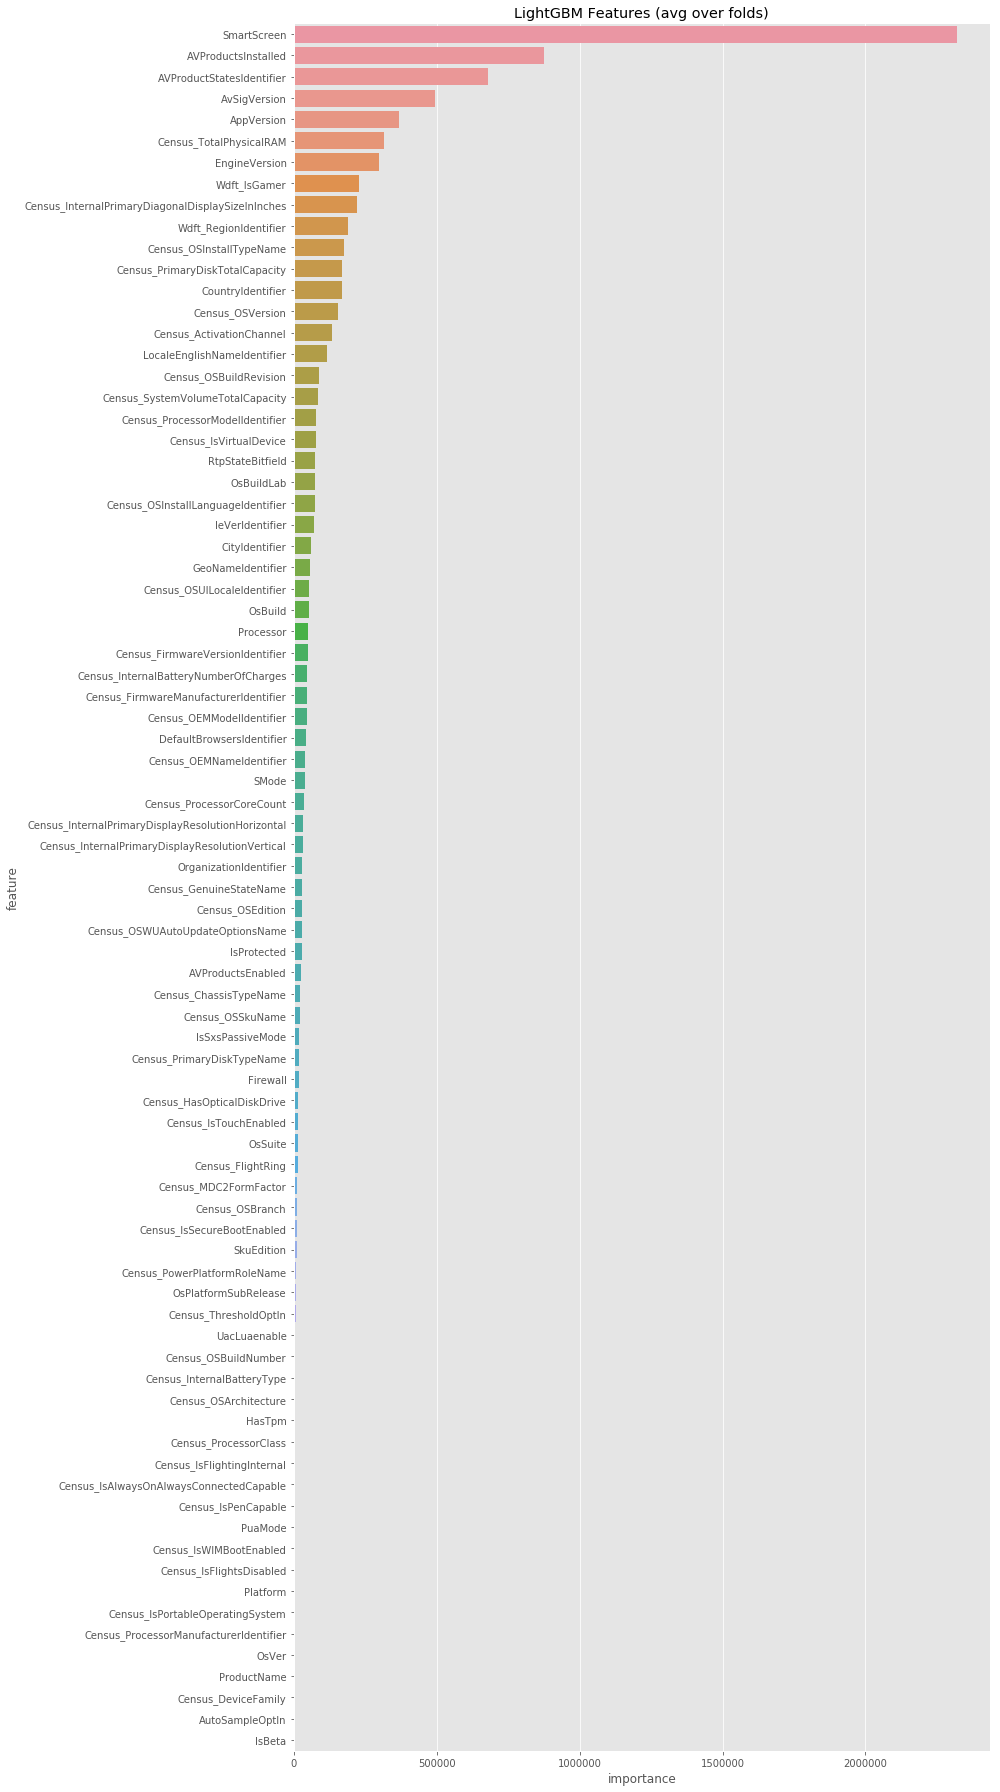

In [18]:
models, validation_score = train_model(train.drop('HasDetections', axis=1),
                                      train_y, base_params,
                                      num_round=5120,
                                       early_stopping_rounds=200,
                                      stop_after_fold_number=stop_after_fold_number,
                                      save_feature_importances=True)
del train

In [19]:
submission_data = test[['MachineIdentifier']]
predictions = np.zeros(len(test))
test = test.drop('MachineIdentifier', axis=1)
chunk_size = 1000000
for classifier_model in tqdm(models):
    current_pred = np.zeros(len(test))
    initial_idx = 0
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = classifier_model.predict(test.iloc[idx],
                                                     num_iteration=classifier_model.best_iteration)
        initial_idx = final_idx

    predictions += current_pred / len(models)
del test

In [20]:
submission_data['HasDetections'] = predictions
filename = 'submission_{:.6f}_{}_folds_{}_data.csv'.format(validation_score,
                                                              dt.now().strftime('%Y-%m-%d-%H-%M'),
                                                              len(models))
submission_data.to_csv('single_{}'.format(filename), index=False)